In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255, brightness_range=[0.2,0.7])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 2015 images belonging to 112 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224),batch_size=8, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
from keras.applications import VGG16

In [ ]:
conv_base = VGG16(weights='imagenet', include_top= False )

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in conv_base.layers[:15]:
  layer.trainable = False
for layer in conv_base.layers[15:]:
  layer.trainable = True

In [ ]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
from keras.layers import Input

In [ ]:
input_tensor = Input(shape=(224,224,1))
x =Conv2D(3,(3,3), padding='same')(input_tensor)
x = conv_base(x)


In [ ]:
x = Flatten()(x)
x = Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

In [ ]:
ouput = Dense(112, activation='softmax')(x)

In [ ]:
model = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/VGG_16_GrayScale.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=252,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 6.2967 - accuracy: 0.0258
Epoch 00001: val_loss improved from inf to 14.78098, saving model to /content/drive/My Drive/1-piece/VGG_16_GrayScale.h5
252/252 [==============================] - 1111s 4s/step - loss: 6.2967 - accuracy: 0.0258 - val_loss: 14.7810 - val_accuracy: 0.0089
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 5.4038 - accuracy: 0.0501
Epoch 00002: val_loss improved from 14.78098 to 13.23384, saving model to /content/drive/My Drive/1-piece/VGG_16_GrayScale.h5
252/252 [==============================] - 85s 339ms/step - loss: 5.4038 - accuracy: 0.0501 - val_loss: 13.2338 - val_accuracy: 0.0268
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 4.6912 - accuracy: 0.0665
Epoch 00003: val_loss did not improve from 13.23384
252/252 [==============================] - 83s 328ms/step - loss:

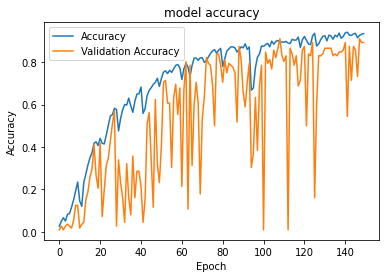

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

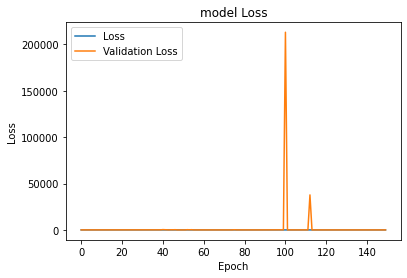

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([  0,   1,  22,   3,   4,   5,  34,   7,   8,  15,  10,  11,  12,
        14,  14,  15,  16,  17,  18,  54,  20,  21,  22,  23,  24,  25,
         0,  33,   2,  26,  30,  35,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  90,  43,  44,  45,  94,  47,  48,  49,  87,  51,
        52,  53,  54,  68,  56,  57,  58,  59,  60,  61,  62,  60,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  52,  76,
        78,  79,  80,  74,  82,  83,  84,  85,  86,  87,  88,  94,  90,
        91,  93, 106,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105,  52, 107, 108, 109, 110, 111])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.8035714285714286


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.7336309523809523


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.8035714285714286


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.755952380952381


**Processinf for Colour Data.**

In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8)

Found 2015 images belonging to 112 classes.


In [ ]:
Colour_ValidData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224), batch_size=8)

Found 112 images belonging to 112 classes.


In [ ]:
conv_base_colour = VGG16(weights = "imagenet", include_top = False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in conv_base_colour.layers[:15]:
  layer.trainable = False
for layer in conv_base_colour.layers[15:]:
  layer.trainable = True

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,3))
x = conv_base_colour(input_tensor)
x = Flatten()(x)
x = Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
ouput = Dense(112, activation='softmax')(x)

In [ ]:
colour_model = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
colour_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/Colour_VGG_16.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = colour_model.fit_generator(steps_per_epoch=252,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 6.3410 - accuracy: 0.0377
Epoch 00001: val_loss improved from inf to 14.52270, saving model to /content/drive/My Drive/1-piece/Colour_VGG_16.h5
252/252 [==============================] - 82s 325ms/step - loss: 6.3410 - accuracy: 0.0377 - val_loss: 14.5227 - val_accuracy: 0.0179
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 5.6055 - accuracy: 0.0491
Epoch 00002: val_loss improved from 14.52270 to 12.40596, saving model to /content/drive/My Drive/1-piece/Colour_VGG_16.h5
252/252 [==============================] - 81s 323ms/step - loss: 5.6055 - accuracy: 0.0491 - val_loss: 12.4060 - val_accuracy: 0.0179
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 4.5843 - accuracy: 0.0784
Epoch 00003: val_loss improved from 12.40596 to 7.59651, saving model to /content/drive/My Drive/1-piece/Colour_VGG_16.h5
252/252 [==============================] - 82s 324ms/step - loss: 4.5843 - a

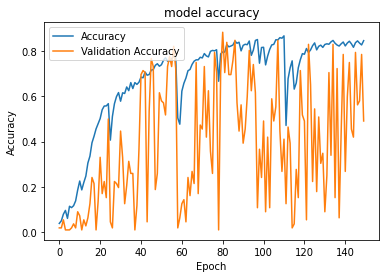

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

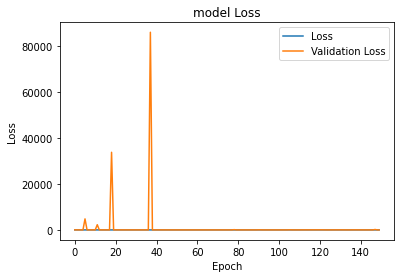

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 112 images belonging to 112 classes.


In [ ]:
Colour_predict = colour_model.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([ 24, 100,  26,   3,   4,   5,  31,  53,   3,  10,  10, 100,  42,
        14,  53,  10,  42,  17,  18,  87,  42,  21,  43,  69,  34,  25,
        26,  34,   2,  29,  30,  25,  32,   4,  34,  35,  36, 100,  38,
        69,  40,  89,  42,  43,  69,  45,  25,  87,  48,  49,  87,  51,
        72,  53,  54,  78,  56,  57,  58,  95,  53,  53,  53,  53,  64,
        53,  66,  53,  66,  69,  70,  71,  72, 101, 100,  69,  53,  77,
        78,  79,  95,  81, 100,  83,  87,  87,  43,  87,  69,  89,  66,
        91,  92,  93,  94,  95,  96,  87,  98,  99, 100, 101, 102,  42,
        42,  25,  59,  24, 108,   2, 110, 111])

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.49107142857142855


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.3853528911564626


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.49107142857142855


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.409425247371676


In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.6696428571428571


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.5809523809523809


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.6696428571428571


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.6038690476190476


In [ ]:
Second_final = 0.5* Colour_predict + 0.5* Grey_predict

In [ ]:
Second_Final_Predict_classes = np.argmax(Second_final, axis=1)

In [ ]:
Mean_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_Final_Predict_classes)
print("Colour Accuracy: ", Mean_Final_accuracy)

Colour Accuracy:  0.8392857142857143


In [ ]:
Mean_Precision = precision_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_Precision

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7782738095238094

In [ ]:
Mean_Recall = recall_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_Recall

0.8392857142857143

In [ ]:
Mean_F1Score = f1_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_F1Score

0.7976190476190477

Plotting GradCam

In [ ]:
!pip install keras==2.2.2

     |████████████████████████████████| 307kB 3.4MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
import keras

Using TensorFlow backend.


In [ ]:
keras.__version__

'2.2.2'

In [ ]:
import tensorflow as tf


In [ ]:
tf.__version__

'1.10.0'

In [ ]:
!pip install tensorflow==1.10.0

     |████████████████████████████████| 58.4MB 75kB/s 
     |████████████████████████████████| 12.2MB 40.6MB/s 
     |████████████████████████████████| 3.3MB 41.0MB/s 
     |████████████████████████████████| 573kB 41.6MB/s 
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.14.5 which is incompatible.
ERROR: tifffile 2020.7.24 has requirement numpy>=1.15.1, but you'll have numpy 1.14.5 which is incompatible.
ERROR: spacy 2.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: pytest-cov 2.10.0 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: numba 0.48.0 has requirement

In [ ]:
!pip install -I scipy==1.1.0

     |████████████████████████████████| 31.2MB 146kB/s 
     |████████████████████████████████| 14.5MB 262kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.2.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install Pillow

In [ ]:
!pip install scikit-image imageio

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
colour_gradCam = VGG16(weights='imagenet', include_top=True)

In [ ]:
colour_gradCam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
import vis ## keras-vis
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

from keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Reading the Colour Image.
colour_imag = load_img('/content/drive/My Drive/1-piece/Test/026 Pinus caribaea/02613.png', target_size=(224,224))

In [ ]:
colour_image_gradCam = load_img('/content/drive/My Drive/1-piece/Test/026 Pinus caribaea/02613.png', target_size=(224,224))

In [ ]:
import vis ## keras-vis
import matplotlib.pyplot as plt

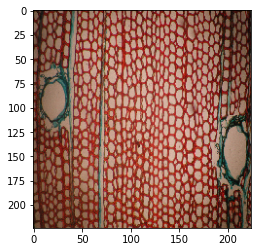

In [ ]:
plt.imshow(colour_image_gradCam)

In [ ]:
colour_image_gradCam = img_to_array(colour_image_gradCam)

In [ ]:
colour_image_gradCam.shape

(224, 224, 3)

In [ ]:
colour_image_gradCam = preprocess_input(colour_image_gradCam)

In [ ]:
y_pred = colour_gradCam.predict(colour_image_gradCam[np.newaxis,...])

In [ ]:
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

In [ ]:
from vis.utils import utils

In [ ]:
layer_idx = utils.find_layer_idx(colour_gradCam,'fc2')

In [ ]:
colour_gradCam.layers[layer_idx].activation = keras.activations.linear

In [ ]:
colour_gradCam = utils.apply_modifications(colour_gradCam)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
!pip install black flake8 pytest pytest-cov sphinx numpydoc

     |████████████████████████████████| 102kB 2.5MB/s 
     |████████████████████████████████| 81kB 2.7MB/s 
     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 747kB 5.8MB/s 
     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 235kB 10.0MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.2.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.2.1 which is incompatible.
ERROR: pytest-cov 2.10.0 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


In [ ]:
import skimage, imageio

In [ ]:
import PIL

In [ ]:
!pip install opencv-contrib-python

In [ ]:
from vis.visualization import  visualize_cam

In [ ]:
penultimate_layer_idx = utils.find_layer_idx(colour_gradCam, 'block5_conv3')

In [ ]:
class_idx = class_idxs_sorted[0]

In [ ]:
seed_input = colour_image_gradCam

In [ ]:
colour_image_gradCam.shape

(224, 224, 3)

In [ ]:
grad_topcolour = visualize_cam(colour_gradCam,layer_idx,class_idx, seed_input,
                               penultimate_layer_idx,
                               backprop_modifier = None,
                               grad_modifier = None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


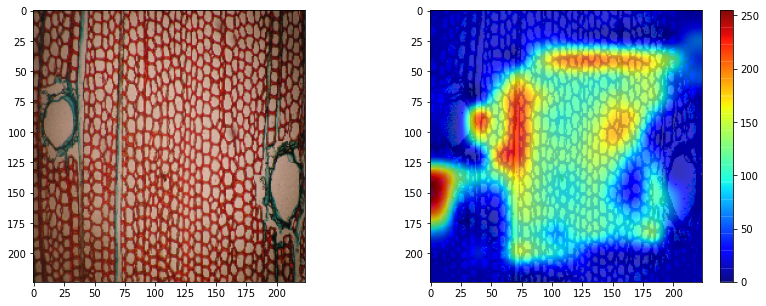

In [ ]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(colour_imag)
    axes[1].imshow(colour_image_gradCam)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
   
plot_map(grad_topcolour)

Grey Scale

In [ ]:
grey_image = load_img('/content/drive/My Drive/1-piece/Test/026 Pinus caribaea/02613.png', grayscale=True, color_mode='grayscale', target_size=(224,224))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
grey_image_grad = load_img('/content/drive/My Drive/1-piece/Test/026 Pinus caribaea/02613.png', grayscale=True, color_mode='grayscale', target_size=(224,224))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


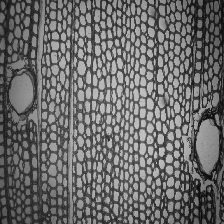

In [ ]:
grey_image

In [ ]:
grey_gradCam = VGG16(weights='imagenet', include_top=True)

In [ ]:
import cv2

In [ ]:
grey_image_grad = cv2.imread('/content/drive/My Drive/1-piece/Test/026 Pinus caribaea/02613.png')

In [ ]:
grey_image_grad = cv2.cvtColor(grey_image_grad, cv2.COLOR_BGR2GRAY)

In [ ]:
grey_image_grad = np.repeat(grey_image_grad[...,np.newaxis],3,-1)

In [ ]:
grey_image_grad.shape

(768, 1024, 3)

In [ ]:
grey_image_grad_resize = cv2.resize(grey_image_grad,(224,224))

In [ ]:
grey_image_grad_resize.shape

(224, 224, 3)

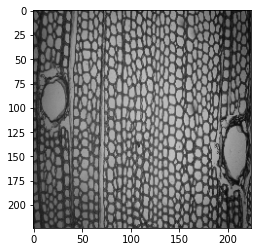

In [ ]:
plt.imshow(grey_image_grad_resize)

In [ ]:
grey_image_grad_resize_array = img_to_array(grey_image_grad_resize)

In [ ]:
grey_image_grad_resize_array = preprocess_input(grey_image_grad_resize_array)

In [ ]:
grey_image_grad_resize_array.shape

(224, 224, 3)

In [ ]:
yhat = grey_gradCam.predict(grey_image_grad_resize_array[np.newaxis,...])

In [ ]:
grey_class_idxs_sorted = np.argsort(yhat.flatten())[::-1]

In [ ]:
layer_idx = utils.find_layer_idx(grey_gradCam,'fc2')

In [ ]:
grey_gradCam.layers[layer_idx].activation = keras.activations.linear

In [ ]:
grey_gradCam = utils.apply_modifications(grey_gradCam)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
penultimate_layer_idx = utils.find_layer_idx(grey_gradCam, 'block5_conv3')

In [ ]:
class_idx = grey_class_idxs_sorted[0]

In [ ]:
seed_input = grey_image_grad_resize

In [ ]:
seed_input.shape

(224, 224, 3)

<tf.Tensor 'input_1_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [ ]:
grey_image_grad_resize.shape

(224, 224, 3)

In [ ]:
grad_grey = visualize_cam(grey_gradCam,layer_idx,class_idx, seed_input,
                               penultimate_layer_idx,
                               backprop_modifier = None,
                               grad_modifier = None)

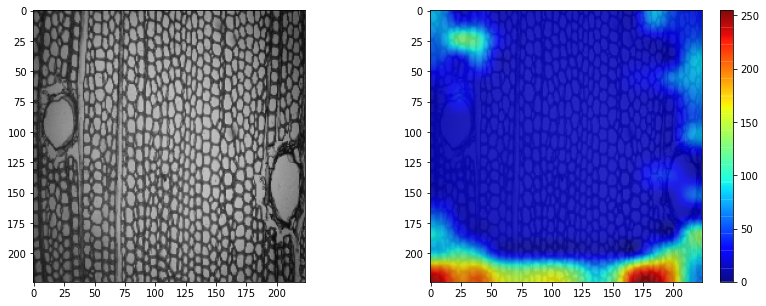

In [ ]:
def plot_map(grads):
  fig, axes = plt.subplots(1,2,figsize=(14,5))
  axes[0].imshow(grey_image_grad_resize)
  axes[1].imshow(grey_image_grad_resize)
  i = axes[1].imshow(grads, cmap = "jet", alpha = 0.8)
  fig.colorbar(i)

plot_map(grad_grey)

In [ ]:
combine_gradCam = VGG16(weights='imagenet', include_top=True)

In [ ]:
combine = 0.6*y_pred + 0.4* yhat

In [ ]:
combine_class_idxs_sorted = np.argsort(combine.flatten())[::-1]

In [ ]:
layer_idx = utils.find_layer_idx(combine_gradCam,'fc2')

In [ ]:
combine_gradCam.layers[layer_idx].activation = keras.activations.linear

In [ ]:
combine_gradCam = utils.apply_modifications(combine_gradCam)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
penultimate_layer_idx = utils.find_layer_idx(combine_gradCam, 'block5_conv3')

In [ ]:
class_idx = combine_class_idxs_sorted[0]

In [ ]:
seed_input = colour_image_gradCam

In [ ]:
grad_topcombine = visualize_cam(combine_gradCam,layer_idx,class_idx, seed_input,
                               penultimate_layer_idx,
                               backprop_modifier = None,
                               grad_modifier = None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


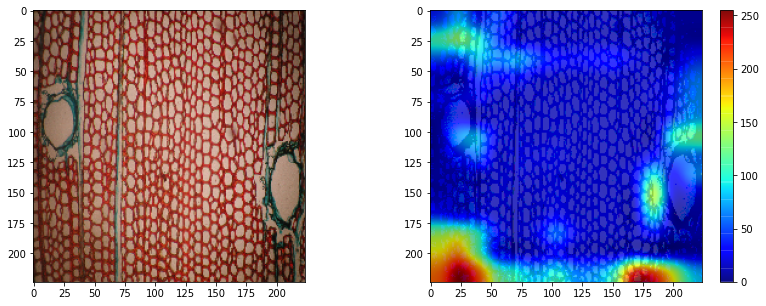

In [ ]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(colour_imag)
    axes[1].imshow(colour_image_gradCam)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
   
plot_map(grad_topcolour)